# **_INSTALL DEPENDENCIES_**

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from numpy import exp
from scipy.optimize import fmin_cg, minimize
from IPython.display import Markdown, display

FILES = "Files"
EX4DATA1 = FILES + "/ex4data1.mat"
EX4WEIGHTS = FILES + "/ex4weights.mat"

# with open('../README.md', 'r', encoding='utf-8') as f:
#     display(Markdown(f.read()))

# Step 1: Helper Functions

In [15]:
def debugInitializeWeights(fan_out, fan_in):
    """Return W shaped (fan_out, 1 + fan_in) using sin for reproducibility."""
    
    W = np.zeros((fan_out, 1 + fan_in))
    W = np.reshape(np.sin(np.arange(1, W.size + 1)), W.T.shape).T / 10.0
    
    return W

In [16]:
def computeNumericalGradient(J, theta):
    """Return numerical gradient array for function J around theta.
    J(theta) must return either cost or (cost, grad) — first element is taken."""

    numgrad = np.zeros(theta.shape[0])
    perturb = np.zeros(theta.shape[0])
    e = 1e-4

    for p in range(theta.size):
        perturb[p] = e
        loss1 = J(theta - perturb)
        loss2 = J(theta + perturb)
        v1 = loss1[0] if hasattr(loss1, "__len__") else loss1
        v2 = loss2[0] if hasattr(loss2, "__len__") else loss2
        numgrad[p] = (v2 - v1) / (2 * e)
        perturb[p] = 0

    return numgrad

In [17]:
def sigmoid(z):
    return 1.0 / (1.0 + exp(-z))

In [18]:
def sigmoidGradient(z):
    gz = sigmoid(z)

    return gz * (1 - gz)

In [19]:
def randInitializeWeights(L_in, L_out):
    """Randomly initialize W of shape (L_out, 1 + L_in) in small range."""

    eps = 0.003
    W = np.random.rand(L_out, L_in + 1) * (2 * eps) - eps

    return W

In [20]:
def displayData(X, example_width=None):
    m, n = X.shape
    if example_width is None:
        example_width = int(round(np.sqrt(n)))

    example_height = int(n / example_width)
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    pad = 1
    out_height = pad + display_rows * (example_height + pad)
    out_width = pad + display_cols * (example_width + pad)
    display_array = -np.ones((out_height, out_width))

    curr_ex = 0

    for j in range(display_rows):
        for i in range(display_cols):
            if curr_ex >= m:
                break
            max_val = np.max(np.abs(X[curr_ex, :]))
            if max_val == 0:
                max_val = 1
            row_start = pad + j * (example_height + pad)
            col_start = pad + i * (example_width + pad)
            display_array[row_start:row_start + example_height, col_start:col_start + example_width] = \
                X[curr_ex, :].reshape(example_height, example_width) / max_val
            curr_ex += 1
        if curr_ex >= m:
            break

    plt.imshow(display_array.T, cmap='gray')
    plt.axis('off')
    plt.show()

In [21]:
def predict(Theta1, Theta2, X):
    m = X.shape[0]
    a1 = np.c_[np.ones((m, 1)), X]
    
    z2 = a1.dot(Theta1.T)
    a2 = sigmoid(z2)
    a2 = np.c_[np.ones((m, 1)), a2]
    
    z3 = a2.dot(Theta2.T)
    a3 = sigmoid(z3)
    p = np.argmax(a3, axis=1) + 1
    
    return p

In [22]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda=0):
    # Reshape (Fortran order)
    Theta1 = np.reshape(
        nn_params[: hidden_layer_size * (input_layer_size + 1)],
        (hidden_layer_size, input_layer_size + 1), order="F"
    ).copy()
    Theta2 = np.reshape(
        nn_params[hidden_layer_size * (input_layer_size + 1):],
        (num_labels, hidden_layer_size + 1), order="F"
    ).copy()

    m = X.shape[0]
    
    # Forward
    a1 = np.c_[np.ones(m), X]
    z2 = a1.dot(Theta1.T)
    a2 = np.c_[np.ones(m), sigmoid(z2)]
    z3 = a2.dot(Theta2.T)
    a3 = sigmoid(z3)

    # Cost
    J = 0.0
    for i in range(m):
        one_hot = np.zeros(num_labels)
        one_hot[int(y[i]) - 1] = 1
        J += -one_hot.dot(np.log(a3[i])) - (1 - one_hot).dot(np.log(1 - a3[i]))
    J /= m
    
    # Regularize (exclude bias)
    reg = (np.sum(Theta1[:, 1:] ** 2) + np.sum(Theta2[:, 1:] ** 2)) / (2 * m)
    J += Lambda * reg

    # Backprop (loop)
    Theta1_grad = np.zeros_like(Theta1)
    Theta2_grad = np.zeros_like(Theta2)
    for i in range(m):
        one_hot = np.zeros(num_labels)
        one_hot[int(y[i]) - 1] = 1
        delta3 = a3[i, :] - one_hot
        delta2 = Theta2.T.dot(delta3)[1:] * sigmoidGradient(z2[i, :])
        Theta1_grad += np.outer(a1[i, :], delta2).T
        Theta2_grad += np.outer(a2[i, :], delta3).T

    Theta1_grad /= m
    Theta2_grad /= m
    
    # Regularize gradients (not bias)
    Theta1_grad[:, 1:] += Lambda * (Theta1[:, 1:] / m)
    Theta2_grad[:, 1:] += Lambda * (Theta2[:, 1:] / m)

    grad = np.hstack((Theta1_grad.T.ravel(), Theta2_grad.T.ravel()))
    
    return J, grad

In [23]:
def checkNNGradients(Lambda=0):
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size)
    
    X = debugInitializeWeights(m, input_layer_size - 1)
    y = np.mod(np.arange(1, m + 1), num_labels)
    
    nn_params = np.hstack((Theta1.T.ravel(), Theta2.T.ravel()))
    costFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda)
    
    J, grad = costFunc(nn_params)
    numgrad = computeNumericalGradient(costFunc, nn_params)
    
    print(np.column_stack((numgrad, grad)))
    
    diff = np.linalg.norm(numgrad - grad) / np.linalg.norm(numgrad + grad)
    print("Relative Difference:", diff)
    
    return diff

# Step 2: Load Data and Visualize

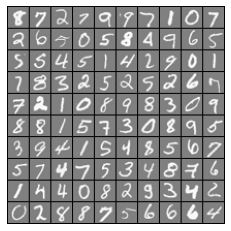

In [24]:
data = scipy.io.loadmat(EX4DATA1)
X = data['X']
y = np.squeeze(data['y'])
m = X.shape[0]

# Show 100 random examples
rand_indices = np.random.permutation(range(m))
sel = X[rand_indices[:100], :]
displayData(sel)

# Step 3: Load Saved Weights and Check Cost (unregularized & regularized)

In [29]:
weights = scipy.io.loadmat(EX4WEIGHTS)
Theta1 = weights['Theta1']
Theta2 = weights['Theta2']
nn_params = np.hstack((Theta1.T.ravel(), Theta2.T.ravel()))

J, _ = nnCostFunction(nn_params, 400, 25, 10, X, y, Lambda=0)
print("Cost (lambda=0):", J)   # expected ~0.287530

J_reg, _ = nnCostFunction(nn_params, 400, 25, 10, X, y, Lambda=1)
print("Cost (lambda=1):", J_reg)  # expected ~0.383670

Cost (lambda=0): 0.28762916516131876
Cost (lambda=1): 0.3837698590909235


# Step 4: Run Gradient Checks (no reg and with reg)

In [30]:
print("Gradient check (lambda=0)")
_ = checkNNGradients(0)

print("\nGradient check (lambda=3)")
_ = checkNNGradients(3)

Gradient check (lambda=0)
[[-6.89656094e-03 -6.89656094e-03]
 [ 7.67737085e-03  7.67737086e-03]
 [-8.32291332e-03 -8.32291333e-03]
 [ 8.77682038e-03  8.77682039e-03]
 [-9.05665002e-03 -9.05665003e-03]
 [-6.18529405e-05 -6.18529364e-05]
 [ 5.98779804e-05  5.98779807e-05]
 [-5.72729464e-05 -5.72729496e-05]
 [ 5.31818833e-05  5.31818835e-05]
 [-4.75743156e-05 -4.75743161e-05]
 [-3.85871139e-04 -3.85871138e-04]
 [ 3.43761066e-04  3.43761067e-04]
 [-2.95279070e-04 -2.95279068e-04]
 [ 2.40148890e-04  2.40148891e-04]
 [-1.80502866e-04 -1.80502863e-04]
 [-1.57061164e-04 -1.57061164e-04]
 [ 1.35146050e-04  1.35146050e-04]
 [-1.10246061e-04 -1.10246062e-04]
 [ 8.30604363e-05  8.30604350e-05]
 [-5.48293588e-05 -5.48293574e-05]
 [ 1.14544970e-01  1.14544970e-01]
 [ 1.11056588e-01  1.11056588e-01]
 [ 2.97400697e-01  2.97400697e-01]
 [ 5.93886843e-02  5.93886843e-02]
 [ 5.75628222e-02  5.75628222e-02]
 [ 1.55170547e-01  1.55170547e-01]
 [ 5.96082205e-02  5.96082205e-02]
 [ 5.78840672e-02  5.78840672

# Step 5: Train the Network

In [38]:
Lambda = 1
costFunc = lambda p: nnCostFunction(p, 400, 25, 10, X, y, Lambda)[0]
gradFunc = lambda p: nnCostFunction(p, 400, 25, 10, X, y, Lambda)[1]

initial_Theta1 = randInitializeWeights(400, 25)
initial_Theta2 = randInitializeWeights(25, 10)
initial_nn_params = np.hstack((initial_Theta1.T.ravel(), initial_Theta2.T.ravel()))

result = minimize(costFunc, initial_nn_params, method='CG', jac=gradFunc, options={'disp': True, 'maxiter': 50})
nn_params_opt = result.x

Theta1_opt = np.reshape(nn_params_opt[: 25 * (400 + 1)], (25, 400 + 1), order='F')
Theta2_opt = np.reshape(nn_params_opt[25 * (400 + 1):], (10, 25 + 1), order='F')

pred = predict(Theta1_opt, Theta2_opt, X)
accuracy = np.mean(pred.flatten() == y.flatten()) * 100

print('Training Set Accuracy: {:.2f}%'.format(accuracy))

         Current function value: 0.500513
         Iterations: 50
         Function evaluations: 117
         Gradient evaluations: 117
Training Set Accuracy: 94.72%


# Step 6: Visualize Learned Features

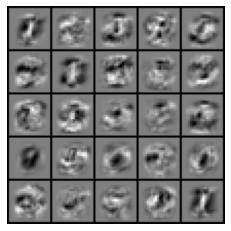

Training Set Accuracy: 94.72%


In [39]:
Theta1_vis = Theta1_opt
Theta2_vis = Theta2_opt

# Visualize hidden units (exclude bias column)
displayData(Theta1_vis[:, 1:])

# compute accuracy
p = predict(Theta1_opt, Theta2_opt, X)

acc = np.mean(p.flatten() == y.flatten()) * 100
print("Training Set Accuracy: {:.2f}%".format(acc))